In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Auctions.csv to Auctions.csv


In [3]:
#this file was compiled via the auctioneer parser
df = pd.read_csv(open("Auctions.csv", "r"))

In [4]:
#exploring the dataset
df = df[['Item Name', 'Item ID', 'Bid', 'Buyout', 'Scantime', 'Seller', 'Quantity', 'Day']]
df.iloc[15000:15005]

,Item Name,Item ID,Bid,Buyout,Scantime,Seller,Quantity,Day
15000,"\""Rugged Hide\""",8171,22160,23328,1601540200,"\""\""",4,3
15001,"\""Recipe: Transmute Mithril to Truesilver\""",9305,75999,79999,1601540200,"\""\""",1,3
15002,"\""Strong Fishing Pole\""",6365,26029,27399,1601540200,"\""\""",1,3
15003,"\""Elixir of Water Breathing\""",5996,9260,9748,1601540200,"\""\""",1,3
15004,"\""Shadow Protection Potion\""",6048,165000,165000,1601540200,"\""\""",5,3


In [27]:
#list of item ids that are worth looking at, used regularly
item_ids = [13444, 20520, 13510, 13454, 13452, 12431, 20452, 12820, 13442, 13458, 13457, 13459, 13456, 20748, 20749, 13931, 7676, 5634, 12363, 13468, 13467, 13466, 13465, 13463, 8845, 14047, 14551]

In [6]:
#sanity check to make sure that there are 7 days of data collection
df['Day'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [7]:
#THIS FUNCTION takes in the whole df, and the desired item id
#it returns a list of lists
#each item is [day, price]

#this is super necessary as it accounts for items with higher quantity than 1, and lists them as multiple individual items using avg. price

def day_price_parser(df_arg, item_id):
  reduced_df = df_arg[df_arg['Item ID']==item_id]

  #catch errors
  if reduced_df.empty:
    print("No data for item id:", item_id)
    return [[],[]]

  days = reduced_df['Day'].unique().tolist()
  prices = []
  for day in days:
    prices_df = reduced_df[reduced_df['Day']==day]
    for x in prices_df.iterrows():
      for i in range(x[1][6]):
        #divide by 10000 to go from copper (database representation) -> gold
        prices.append([day,(x[1][3]/x[1][6])/10000])
  return prices

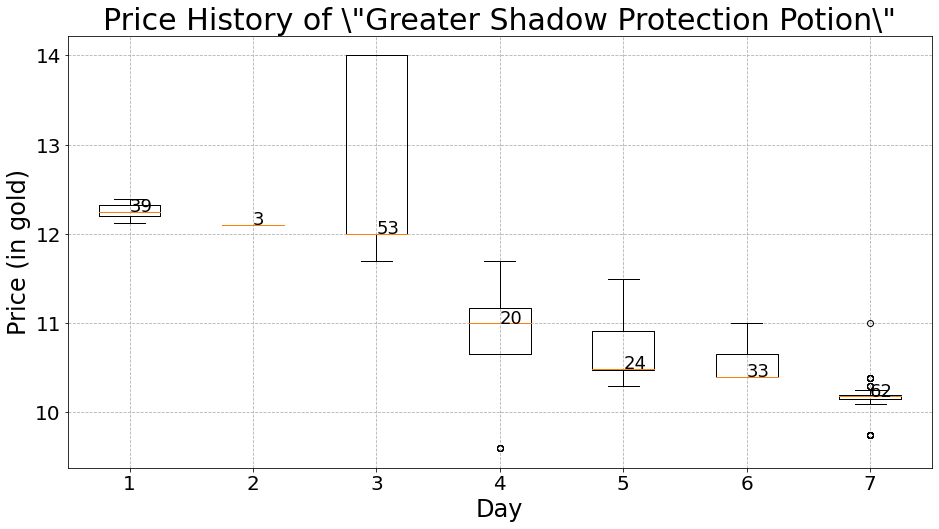

In [8]:
#this function takes in the whole df and the item id, then constructs a box plot based on prices and items seen
def box_plot_items(df_arg, item_id):
  #this is a really lazy way of doing this
  item_name = df_arg[df_arg['Item ID']==item_id]['Item Name'].iloc[0]

  prices = day_price_parser(df_arg, item_id)

  #if there are days where no data exists, ensure that no price data is added to those days
  days = []
  for i in prices:
    if (i[0] not in days):
      days.append(i[0])

  #list (days) of lists (prices on each day)
  list_of_lists_prices = []
  for day in days:
    temp = []
    for x in prices:
      if (x[0]==day):
        temp.append(x[1])
    list_of_lists_prices.append(temp)

  #how many of an item there are on each day
  quantities = []
  for i in list_of_lists_prices:
    quantities.append(len(i))

  #make the plot look nice
  plt.rc('axes', titlesize=30)
  plt.rc('axes', labelsize=24)
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)

  fig = plt.figure(figsize =(12, 6)) 
  ax = fig.add_axes([0, 0, 1, 1]) 
  bp = ax.boxplot(list_of_lists_prices) 

  #set up labels
  x_labels = []
  q=0
  for day in days:
    x_labels.append(str(day))
    q+=1

  ax.set_xticklabels(x_labels)

  plt.title("Price History of " + item_name) 

  plt.xlabel('Day')
  plt.ylabel('Price (in gold)')

  #graphical annotations
  for i in range(len(days)):
    ax.annotate(str(quantities[i]), xy=(i+1,np.median(list_of_lists_prices[i])), xycoords = 'data', size=18)

  plt.grid(ls='--')

  plt.show() 

#test function

#major mana is 13444
#crystal is 12363
#rorb is 12811
#GSPP is 13459
#GNPP is 13458
box_plot_items(df,13459)

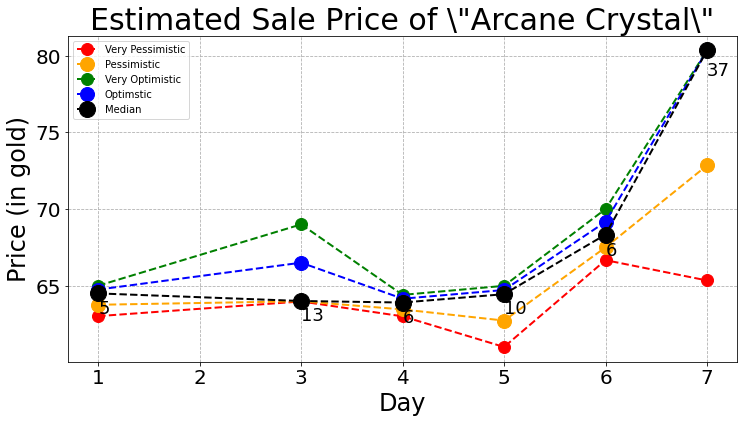

In [9]:
#this function will take in the df and item id and print out a nice estimated sale price based on median prices each day
def ts_sale_price(df_arg, item_id):
  item_name = df_arg[df_arg['Item ID']==item_id]['Item Name'].iloc[0]

  prices = day_price_parser(df_arg, item_id)
  days = []
  for i in prices:
    if (i[0] not in days):
      days.append(i[0])

  list_of_lists_prices = []
  for day in days:
    temp = []
    for x in prices:
      if (x[0]==day):
        temp.append(x[1])
    list_of_lists_prices.append(temp)

  #finds the median price, lowest price, and highest price of each day
  median_prices = []
  price_ranges = []
  for l in list_of_lists_prices:
    median_prices.append(np.median(l))
    ls = sorted(l)
    price_ranges.append([ls[0],ls[-1]])

  #time series, (very) optimistic/pessimistic, see report for explanation of this calculation
  ts_v_optimistic = []
  ts_v_pessimistic = []
  ts_optimistic = []
  ts_pessimistic = []

  #q is an index value because i am lazy
  q = 0
  for x in price_ranges:
    ts_v_optimistic.append(x[1])
    ts_v_pessimistic.append(x[0])
    ts_optimistic.append(((x[1]-median_prices[q])/2)+median_prices[q])
    ts_pessimistic.append(((x[0]-median_prices[q])/2)+median_prices[q])
    q += 1

  fig = plt.figure(figsize =(12, 6)) 
  plt.title("Estimated Sale Price of " + item_name) 
  plt.xlabel('Day')
  plt.ylabel('Price (in gold)')

  plt.plot(days, ts_v_pessimistic, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Very Pessimistic')
  plt.plot(days, ts_pessimistic, color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=14, label='Pessimistic')

  plt.plot(days, ts_v_optimistic, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Very Optimistic')
  plt.plot(days, ts_optimistic, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=14, label='Optimstic')

  plt.plot(days, median_prices, color='black', marker='o', linestyle='dashed', linewidth=2, markersize=16, label='Median')

  #annotations, there might be some problems with the positioning if the price range is very low but the prices are very high
  plt.legend()
  q = 0
  for i in days:
    plt.annotate(str(len(list_of_lists_prices[q])), xy=(i,np.median(list_of_lists_prices[q])*0.98), xycoords = 'data', size=18)
    q+=1

  plt.grid(ls='--')
  plt.show()

ts_sale_price(df,12363)

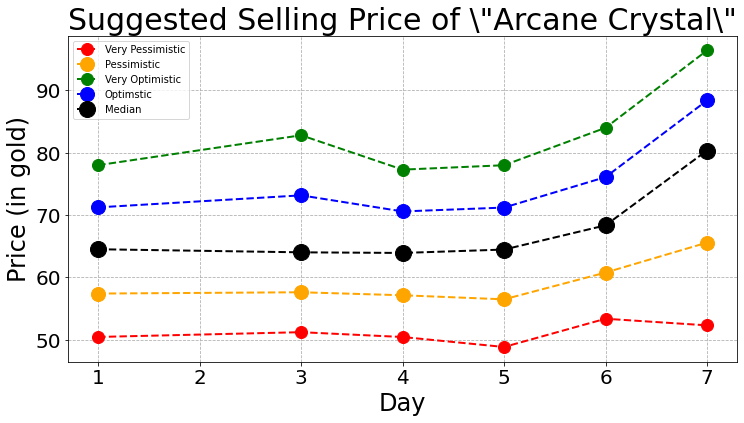

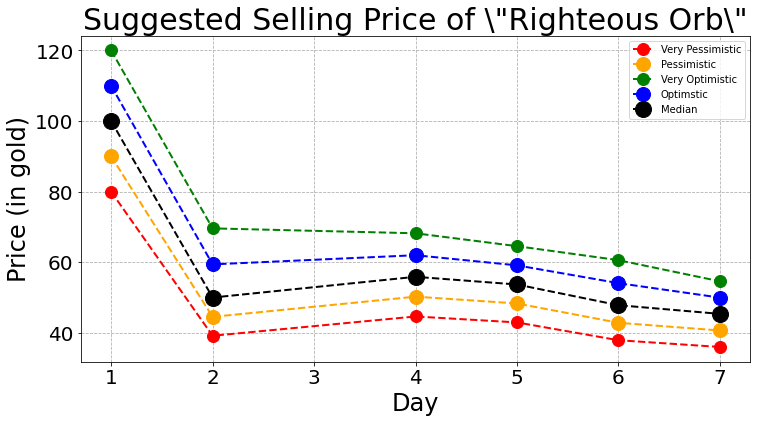

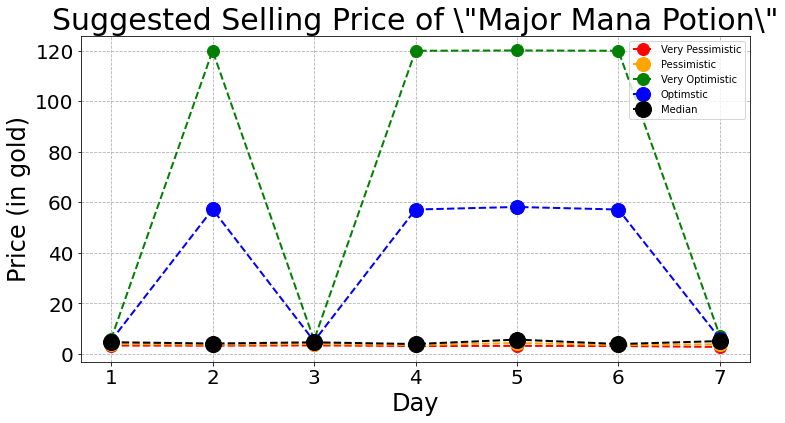

In [10]:
#this function will take in the df and item id and print out a nice suggested sale price based on median prices each day
def suggest_sale_price(df_arg, item_id):
  item_name = df_arg[df_arg['Item ID']==item_id]['Item Name'].iloc[0]

  prices = day_price_parser(df_arg, item_id)
  days = []
  for i in prices:
    if (i[0] not in days):
      days.append(i[0])

  list_of_lists_prices = []
  for day in days:
    temp = []
    for x in prices:
      if (x[0]==day):
        temp.append(x[1])
    list_of_lists_prices.append(temp)

  median_prices = []
  price_ranges = []
  for l in list_of_lists_prices:
    median_prices.append(np.median(l))
    ls = sorted(l)
    price_ranges.append([ls[0],ls[-1]])

  #same as above function, but calculation is a bit different
  ts_v_optimistic = []
  ts_v_pessimistic = []
  ts_optimistic = []
  ts_pessimistic = []
  q = 0
  for x in price_ranges:
    ts_v_optimistic.append(x[1]*1.2)
    ts_v_pessimistic.append(x[0]*0.8)
    ts_optimistic.append((((x[1]-median_prices[q])/2)+median_prices[q])*1.1)
    ts_pessimistic.append((((x[0]-median_prices[q])/2)+median_prices[q])*0.9)
    q += 1

  fig = plt.figure(figsize =(12, 6)) 
  plt.title("Suggested Selling Price of " + item_name) 
  plt.xlabel('Day')
  plt.ylabel('Price (in gold)')

  plt.plot(days, ts_v_pessimistic, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Very Pessimistic')
  plt.plot(days, ts_pessimistic, color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=14, label='Pessimistic')

  plt.plot(days, ts_v_optimistic, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Very Optimistic')
  plt.plot(days, ts_optimistic, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=14, label='Optimstic')

  plt.plot(days, median_prices, color='black', marker='o', linestyle='dashed', linewidth=2, markersize=16, label='Median')

  plt.legend()
  plt.grid(ls='--')
  plt.show()

suggest_sale_price(df,12363)
suggest_sale_price(df,12811)
suggest_sale_price(df,13444)

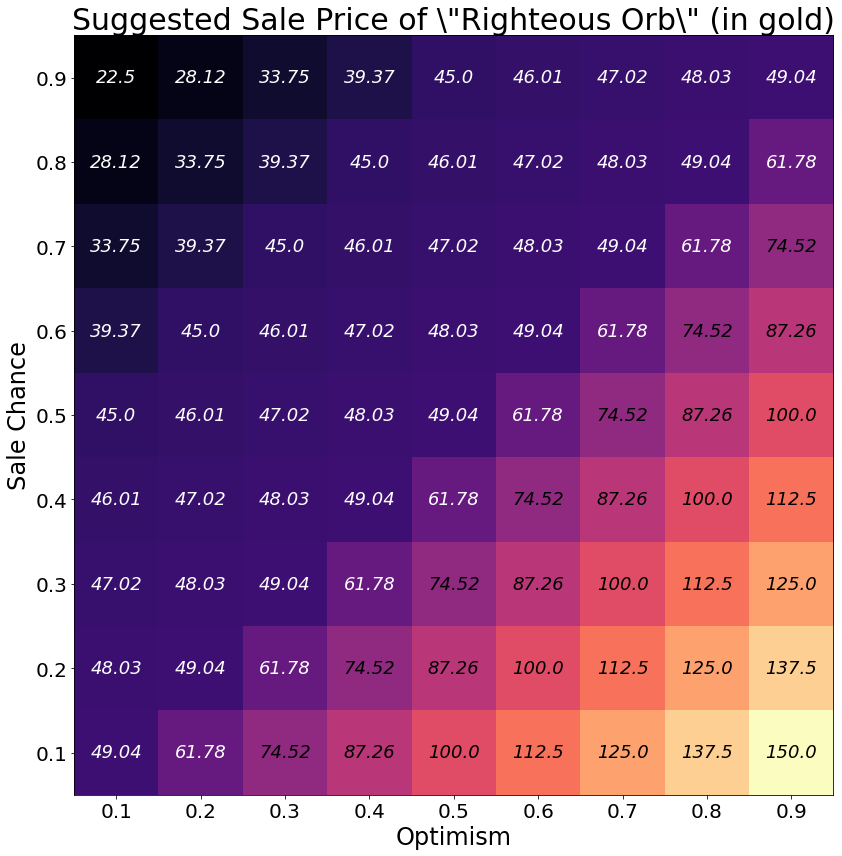

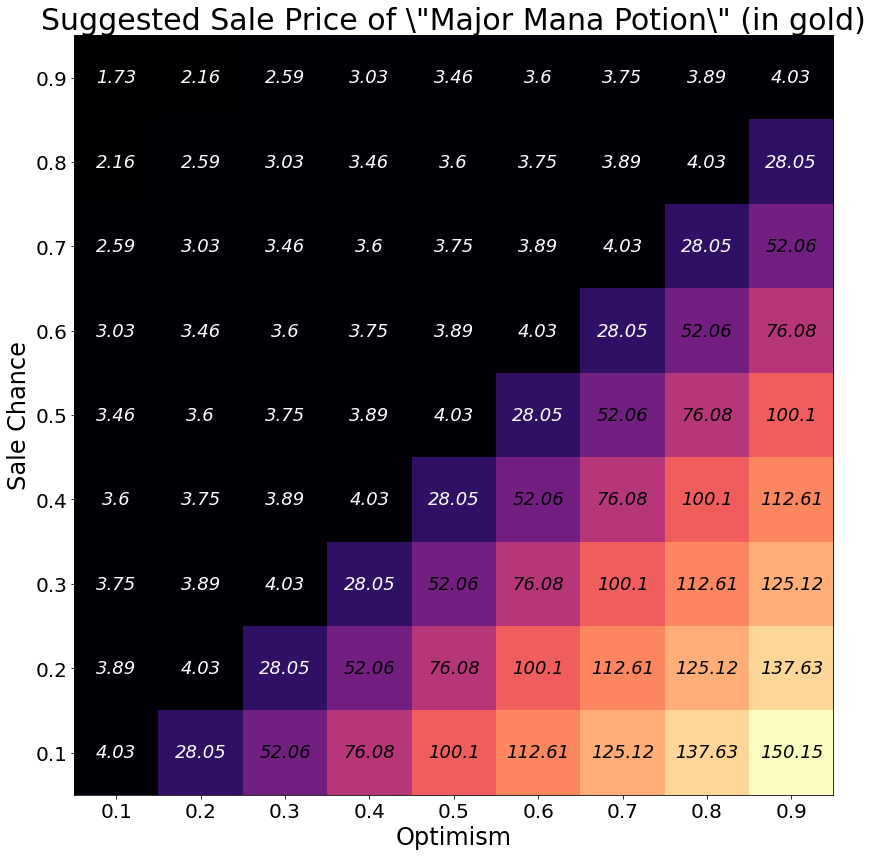

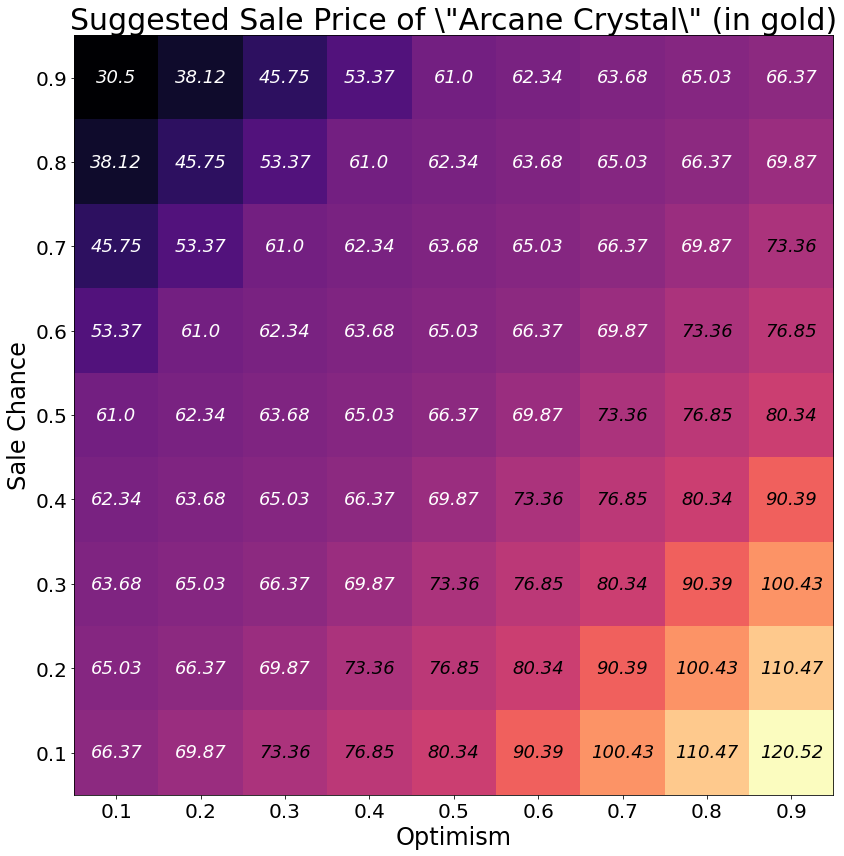

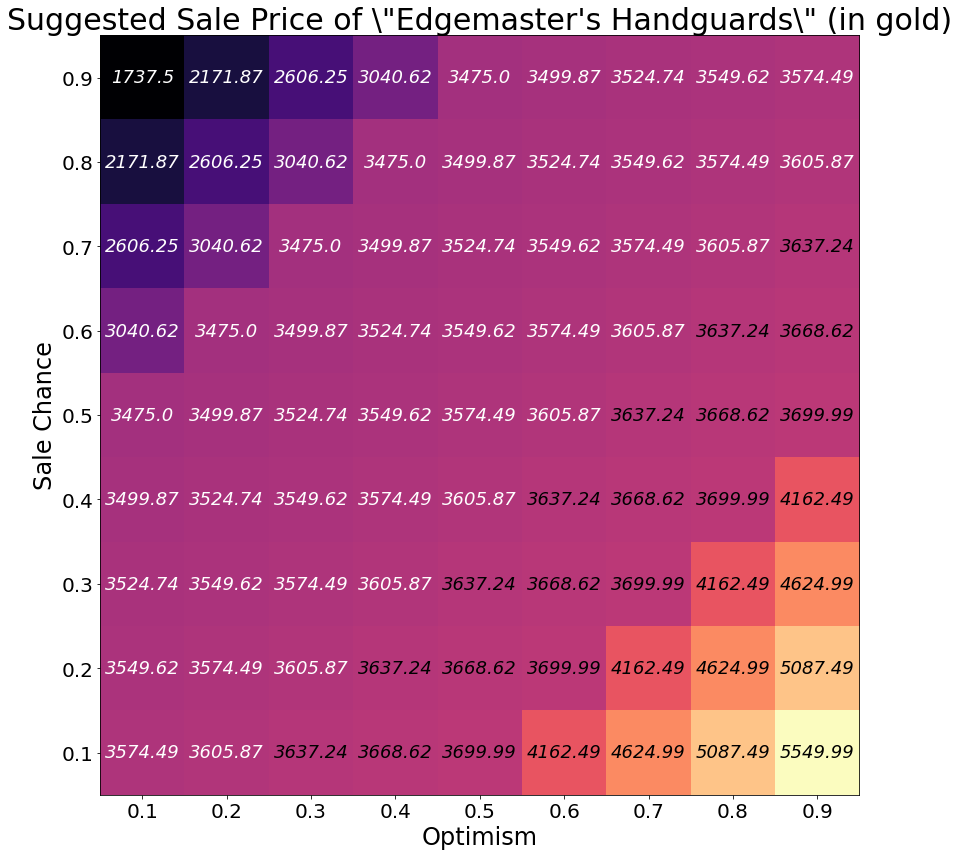

In [31]:
#the big one, suggests sale price based on optimism and sale chance
def optimism_heatmap_week_aggregate(df_arg, item_id):
  item_name = df_arg[df_arg['Item ID']==item_id]['Item Name'].iloc[0]
  prices = day_price_parser(df_arg, item_id)

  price_only = []
  for i in prices:
    price_only.append(i[1])

  ls = sorted(price_only)
  max_price = ls[-1]
  min_price = ls[0]
  median_price = np.median(ls)

  #these are labels for axes
  optimism_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  sale_chance_list = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

  #here is a weird sort of transformation of the prices, it's broken down into basically 4 parts
  sale_vector = []
  for i in range(4,8):
    sale_vector.append((i*min_price)/8)
  for i in range(0,4):
    sale_vector.append((((median_price-min_price)*i)/4)+min_price)
  sale_vector.append(median_price)
  for i in range(1,5):
    sale_vector.append(((i*(max_price-median_price))/4)+median_price)
  for i in range(9,13):
    sale_vector.append((i*max_price)/8)

#queick test to print the sale vector, commented out because it's not necessary
#  print(ls)
#  print(min_price)
#  print(median_price)
#  print(max_price)
#  print(sale_vector)

  #matrix that goes into the heatmap, just shifting the vector around
  heat_matrix = []
  for i in range(9):
    heat_matrix.append(sale_vector[i:i+9])  

  heat_array = np.array(heat_matrix)


  fig, ax = plt.subplots(figsize=(18,12))
  hm = ax.imshow(heat_array, cmap='magma')
  
  ax.set_xticks(np.arange(9))
  ax.set_yticks(np.arange(9))
  ax.set_xticklabels(optimism_list)
  ax.set_yticklabels(sale_chance_list)

  for i in range(9):
    for j in range(9):
      #only difference here is text colour to make it readable against a darker/lighter background
      if((i+j)>9):
        text = ax.text(j, i, np.trunc(heat_array[i, j]*100)/100, ha="center", va="center", color="black", size=18, fontstyle='oblique')
      else:
        text = ax.text(j, i, np.trunc(heat_array[i, j]*100)/100, ha="center", va="center", color="white", size=18, fontstyle='oblique')

  ax.set_title("Suggested Sale Price of "+ item_name +" (in gold)")
  ax.set_ylabel("Sale Chance")
  ax.set_xlabel("Optimism")
  fig.tight_layout()
  plt.show()

optimism_heatmap_week_aggregate(df,12811)
optimism_heatmap_week_aggregate(df,13444)
optimism_heatmap_week_aggregate(df,12363)
optimism_heatmap_week_aggregate(df,14551)

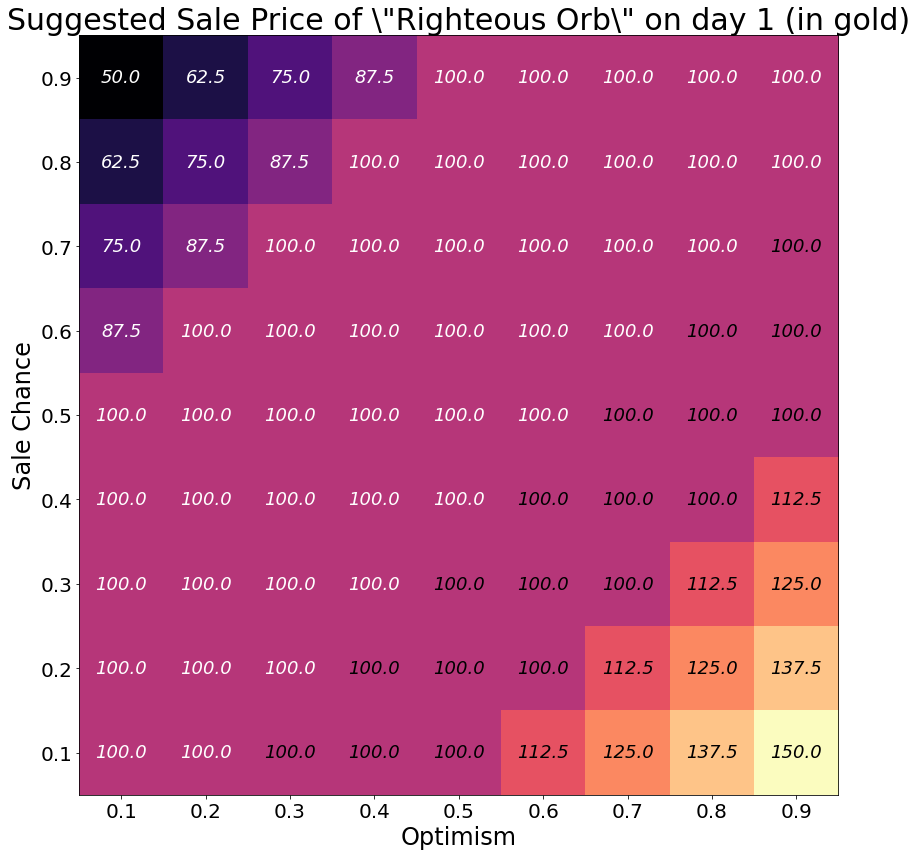

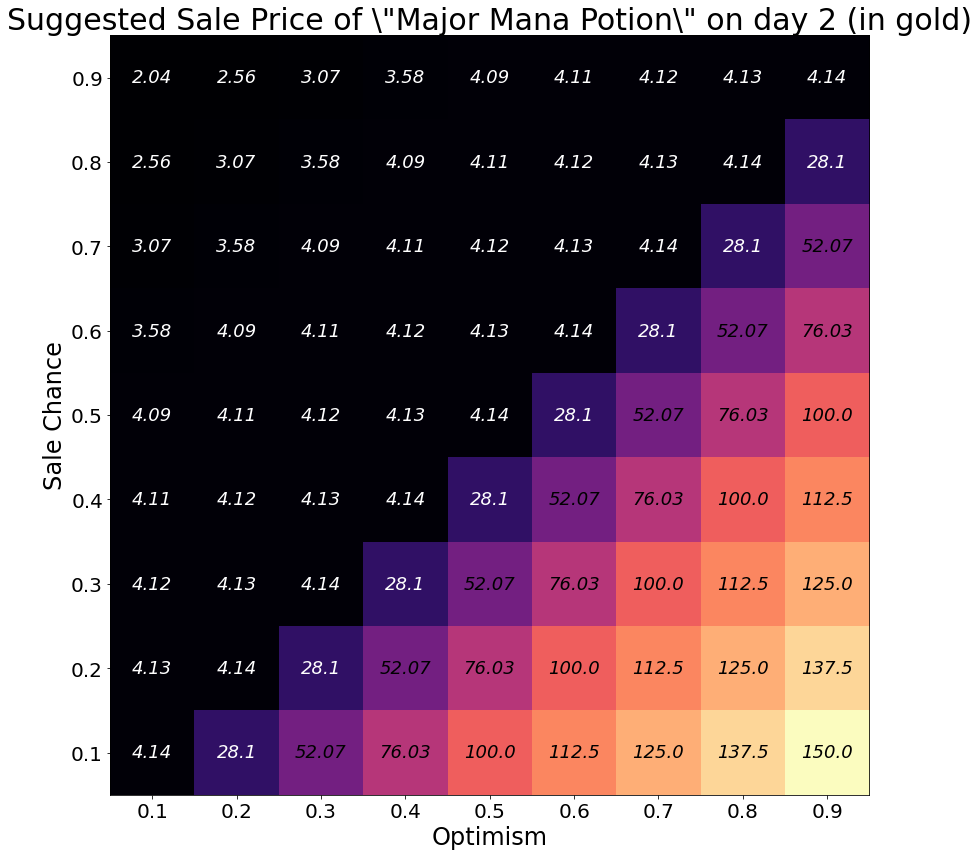

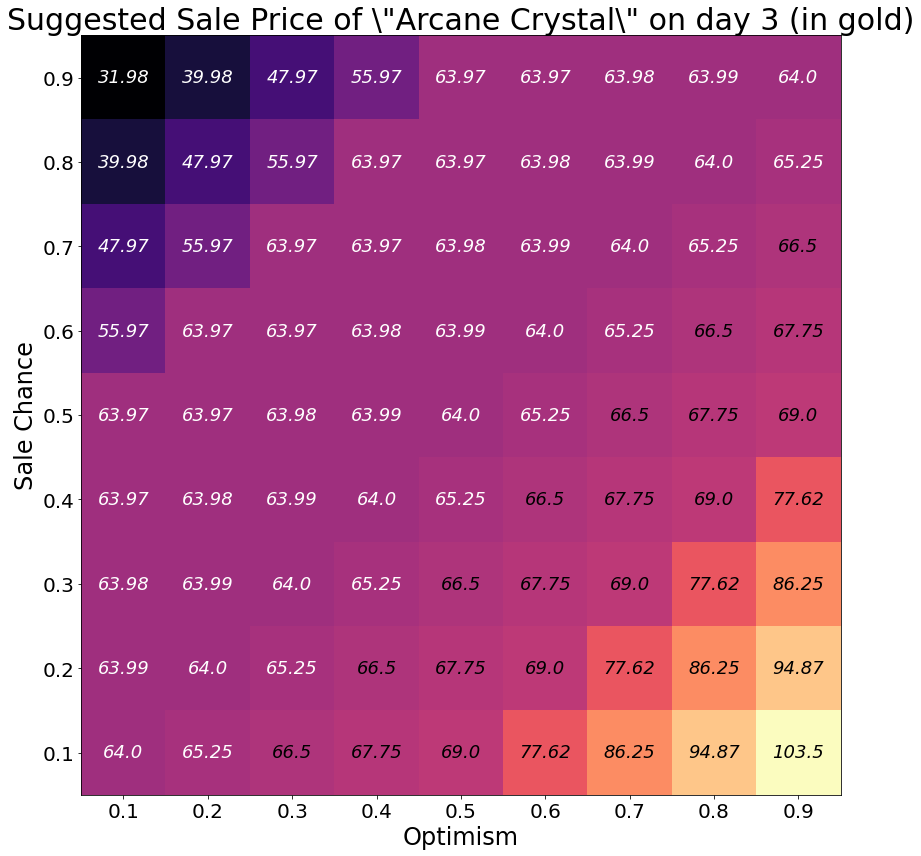

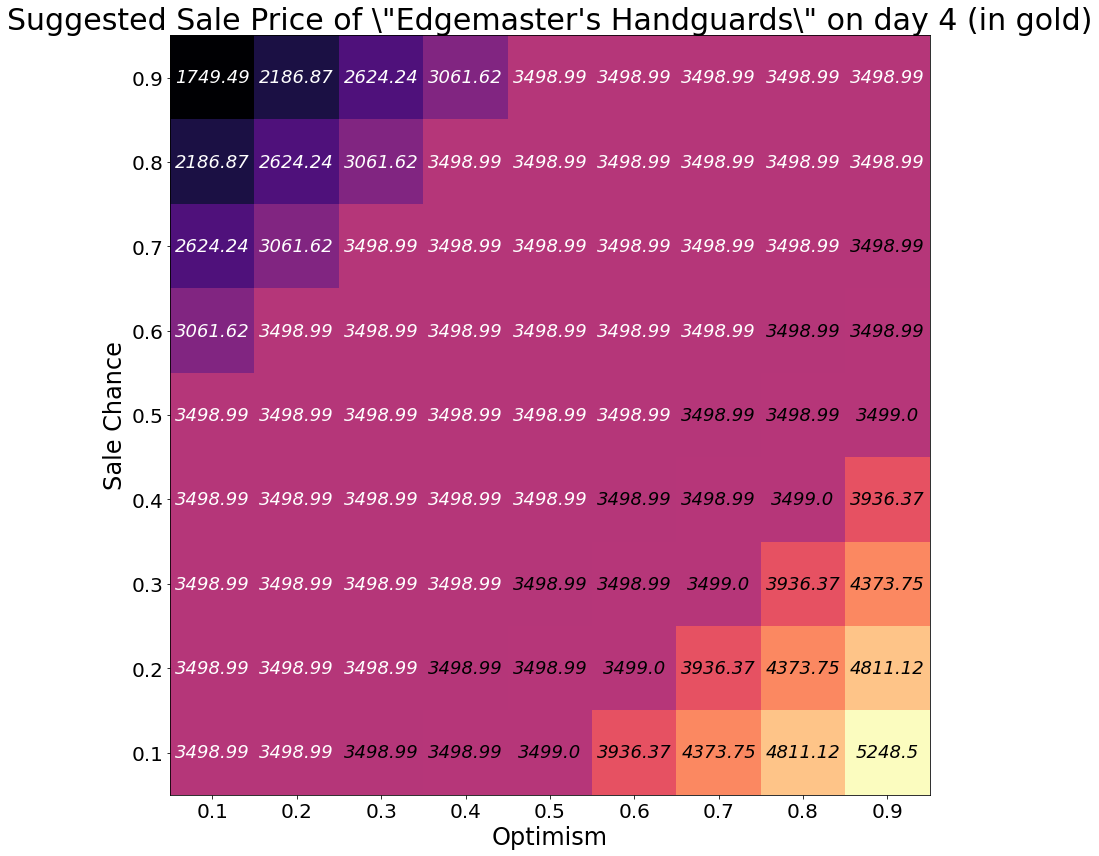

In [21]:
#exact same as above, but with the distinction of only picking one day
def optimism_heatmap_day_aggregate(df_arg, item_id, day_number):
  item_name = df_arg[df_arg['Item ID']==item_id]['Item Name'].iloc[0]
  prices = day_price_parser(df_arg, item_id)

  price_only = []
  for i in prices:
    if (day_number==i[0]):
      price_only.append(i[1])

  ls = sorted(price_only)
  max_price = ls[-1]
  min_price = ls[0]
  median_price = np.median(ls)

  optimism_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  sale_chance_list = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]

  #here is a weird sort of transformation of the prices, it's broken down into basically 4 parts
  sale_vector = []
  for i in range(4,8):
    sale_vector.append((i*min_price)/8)
  for i in range(0,4):
    sale_vector.append((((median_price-min_price)*i)/4)+min_price)
  sale_vector.append(median_price)
  for i in range(1,5):
    sale_vector.append(((i*(max_price-median_price))/4)+median_price)
  for i in range(9,13):
    sale_vector.append((i*max_price)/8)

  heat_matrix = []
  for i in range(9):
    heat_matrix.append(sale_vector[i:i+9])  

  heat_array = np.array(heat_matrix)


  fig, ax = plt.subplots(figsize=(18,12))
  hm = ax.imshow(heat_array, cmap='magma')
  
  ax.set_xticks(np.arange(9))
  ax.set_yticks(np.arange(9))
  ax.set_xticklabels(optimism_list)
  ax.set_yticklabels(sale_chance_list)

  for i in range(9):
    for j in range(9):
      if((i+j)>9):
        text = ax.text(j, i, np.trunc(heat_array[i, j]*100)/100, ha="center", va="center", color="black", size=18, fontstyle='oblique')
      else:
        text = ax.text(j, i, np.trunc(heat_array[i, j]*100)/100, ha="center", va="center", color="white", size=18, fontstyle='oblique')

  ax.set_title("Suggested Sale Price of "+ item_name + " on day " + str(day_number) + " (in gold)")
  ax.set_ylabel("Sale Chance")
  ax.set_xlabel("Optimism")
  fig.tight_layout()
  plt.show()

optimism_heatmap_day_aggregate(df,12811,1)
optimism_heatmap_day_aggregate(df,13444,2)
optimism_heatmap_day_aggregate(df,12363,3)
optimism_heatmap_day_aggregate(df,14551,4)

In [28]:
#putting it all together...
for i in item_ids:
  box_plot_items(df,i)
  ts_sale_price(df,i)
  suggest_sale_price(df,i)
  optimism_heatmap_week_aggregate(df,i)

Output hidden; open in https://colab.research.google.com to view.